In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as md
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import *
import os
import building_blocks
from utils import ConfigSettings


from importlib import reload
reload(building_blocks)
from building_blocks import *

# This is used to plot the graph for {PREDICT_N_STEPS} steps because the full test set is to large to make plots
PREDICT_N_STEPS = 150

device = "cuda" if torch.cuda.is_available() else "cpu"
frequencies = ["4h"]
layers = [2]
heads = [4]
forward_expansions = [256]
encoder_type = "FourierEncoder"
cf = ConfigSettings(config_path='config.ini')
for freq, layer, head, forward_expansion in ([(frequency, num_layer, head, forward_expansion) for frequency in frequencies for num_layer in layers for head in heads for forward_expansion in forward_expansions]):
    model_last_epoch = f"./weights/elia-base-transformer-freq{freq}-layers{layer}-heads{head}-fe{forward_expansion}_model_last_epoch.pth"
    if (not os.path.exists(model_last_epoch)):
        print(f"could not find model last epoch {model_last_epoch}")
    else:
        model_params = generate_model_params(cf, device, encoder_type, layer, head, forward_expansion)
        model = TimeSeriesTransformer.from_params(model_params).to(device)
        print(f"load model from {model_last_epoch}")
        model.load_state_dict(torch.load(model_last_epoch))
        print(f"model loaded succesfully")

        (_, _, test_loader, solar_dataset) = generate_loaders(cf, freq, shuffle=False)

        predictions = np.array([])
        labels = np.array([])
        
        for x_batch, y_batch in tqdm(test_loader):
            model.eval()
            with torch.no_grad():
                y_pred, attention_weights = model(x_batch)
                predictions = np.append(predictions, y_pred.cpu().numpy())


load model from ./weights/elia-base-transformer-freq4h-layers2-heads4-fe256_model_last_epoch.pth
model loaded succesfully


c:\Repositories\OpenUniversiteit\dne\code\datasets.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.target_column] = self.scaler.fit_transform(df[[self.target_column]]).flatten()
100%|██████████| 215/215 [20:46<00:00,  5.80s/it]


In [2]:
original_predictions = solar_dataset.scaler.inverse_transform(predictions.reshape(-1, 1))


RMSE Elias forecast: 1576.2004608557268 MW,  RMSE our forecast: 14295.481527454518


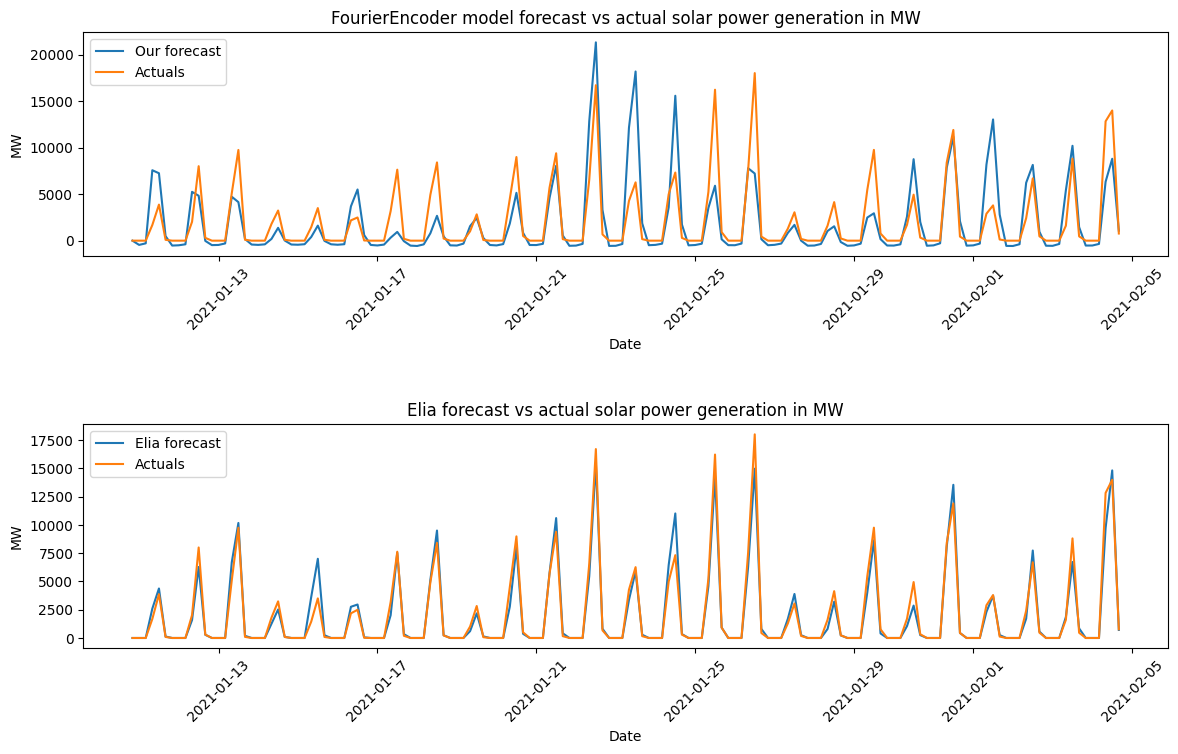

In [30]:
test_df = solar_dataset.get_dataframe().iloc[solar_dataset.train_test_split_index:,:].reset_index(drop=True)
test_df = test_df.iloc[cf.model.context_length:,:].reset_index(drop=True)
y_pred = [0] + [pred for lst in original_predictions for pred in lst]
test_df["predictions"] = y_pred[:-2]
test_df["RMSE_predictions"] = ((test_df["Corrected Upscaled Measurement [MW]"] - test_df["predictions"]) ** 2).mean() ** .5
test_df["RMSE_elia"] = ((test_df["Most recent forecast [MW]"] - test_df["Corrected Upscaled Measurement [MW]"]) ** 2).mean() ** .5
test_df.to_csv((f"data/results_{encoder_type}.csv"))
print(f"RMSE Elias forecast: {test_df['RMSE_elia'].mean()} MW,  RMSE our forecast: {test_df['RMSE_predictions'].mean()}")

plot_df = test_df.iloc[:PREDICT_N_STEPS,:]
fig, ax = plt.subplots(2, 1)
fig.set_figwidth(14)
fig.set_figheight(8)

ax[0].plot(plot_df.DateTime, plot_df.predictions.values, label="Our forecast")
ax[0].plot(plot_df.DateTime, plot_df["Corrected Upscaled Measurement [MW]"].values, label="Actuals")
ax[0].set_title(f"{encoder_type} model forecast vs actual solar power generation in MW")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("MW")
ax[0].legend(loc="upper left")
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(plot_df.DateTime, plot_df["Most recent forecast [MW]"].values, label="Elia forecast")
ax[1].plot(plot_df.DateTime, plot_df["Corrected Upscaled Measurement [MW]"].values, label="Actuals")
ax[1].set_title("Elia forecast vs actual solar power generation in MW")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("MW")
ax [1].legend(loc="upper left")
ax[1].tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.75)
# Save the plot
plt.savefig(f"figures/forecast_vs_actuals_model_{encoder_type}.png")
plt.legend()
# Show the plot
plt.show()


In [ ]:
test_df.head()